In [5]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import torchmetrics
from torchmetrics import Accuracy
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision import transforms

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:


train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   transform =torchvision.transforms.ToTensor(),
                                   download=True,
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  transform=torchvision.transforms.ToTensor(),
                                  download=True,
                                  target_transform=None)


In [9]:


img, label = train_data[0]

def visualize_data(dataset: torchvision.datasets = train_data):
  figure = plt.figure(figsize = (9, 9))
  nrows = 3
  ncols = 3

  for i in range(1, nrows*ncols + 1):
    rand_i = torch.randint(0, len(dataset), size=(1,)).item()
    img, label = dataset[rand_i]
    figure.add_subplot(nrows, ncols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(dataset.classes[label])
    plt.axis(False)

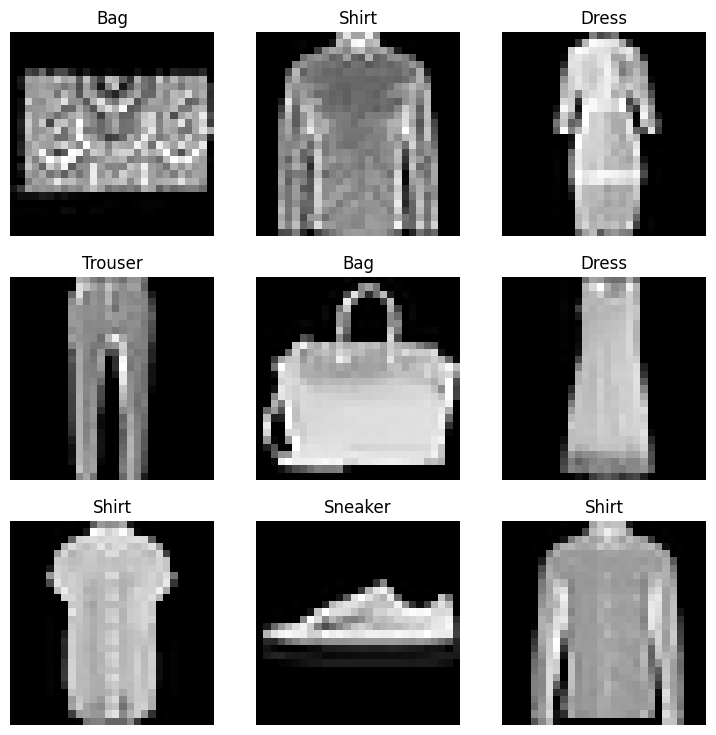

In [10]:
visualize_data(train_data)

In [11]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [12]:
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [13]:
#Tiny VGG architecture

class TinyVGGmodel(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2))
    self.block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(nn.Flatten(),
                                    nn.Linear(in_features=hidden_units*49, out_features=output_shape))

  def forward(self, x):
    x = self.block_1(x)
    #print(f"Shape after block1: {x.shape}")
    x = self.block_2(x)
    #print(f"Shape after block2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape after classifier: {x.shape}")
    return x

  @classmethod
  def tiny_train(cls, dataloader: torch.utils.data.DataLoader, num_epochs: int):
    model = cls(1, 10, 10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    accuracy_fn = Accuracy(task="multiclass", num_classes=10, num_labels=10).to(device)

    for epoch in range(num_epochs):

      train_loss, train_acc = 0, 0
      model.train()

      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_preds.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      train_loss /= len(dataloader)
      train_acc /= len(dataloader)

      print(f"\nEpoch: {epoch}\n")
      print(f"Train loss: {train_loss} | train acc: {train_acc*100}%")

      model.test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
    return model

  def test_step(self, model:nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module, accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        test_preds = model(X)
        test_loss += loss_fn(test_preds, y)
        test_acc += accuracy_fn(y, test_preds.argmax(dim=1))

      test_loss /= len(dataloader)
      test_acc /= len(dataloader)

    print(f"Test loss: {test_loss} | test acc: {test_acc*100}%")


In [14]:
tiny = TinyVGGmodel.tiny_train(dataloader=train_dataloader, num_epochs=3)


Epoch: 0

Train loss: 0.5468478202819824 | train acc: 80.29666900634766%
Test loss: 0.37284547090530396 | test acc: 86.73123168945312%

Epoch: 1

Train loss: 0.3438832759857178 | train acc: 87.66000366210938%
Test loss: 0.32998859882354736 | test acc: 88.11900329589844%

Epoch: 2

Train loss: 0.31343168020248413 | train acc: 88.663330078125%
Test loss: 0.33839908242225647 | test acc: 87.79952239990234%


In [15]:
#Save model state dict
from pathlib import Path

PATH = Path("models")
PATH.mkdir(parents=True, exist_ok=True)

NAME = "model_pytorch.pth"
SAVE_PATH = PATH / NAME

torch.save(obj=tiny.state_dict(), f=SAVE_PATH)

In [16]:
import random
def eval_model(model:nn.Module, data:torchvision.datasets, device:torch.device=device):
  sample_imgs = []
  sample_labels = []
  model_preds = []

  for img, label in random.sample(list(data), k=16):
    sample_imgs.append(img.to(device))
    sample_labels.append(label)

  nrows, ncols = 4, 4
  figure = plt.figure(figsize=(16, 16))

  model.eval()
  with torch.inference_mode():
    for i, img in enumerate(sample_imgs):
      pred = torch.softmax(model(img.unsqueeze(dim=0)), dim=1).argmax(dim=1)
      model_preds.append(pred)
      figure.add_subplot(nrows, ncols, i+1)
      plt.imshow(img.squeeze().cpu(), cmap="gray")
      plt.axis(False)

      if pred == sample_labels[i]:
        plt.title(f"Pred: {data.classes[pred]} Truth: {data.classes[sample_labels[i]]}", fontsize=8, c="g")
      else:
        plt.title(f"Pred: {data.classes[pred]} Truth: {data.classes[sample_labels[i]]}", fontsize=8, c="r")

  return torch.cat(model_preds)





tensor([7, 9, 7, 3, 7, 8, 3, 8, 0, 2, 0, 0, 6, 3, 1, 9], device='cuda:0')

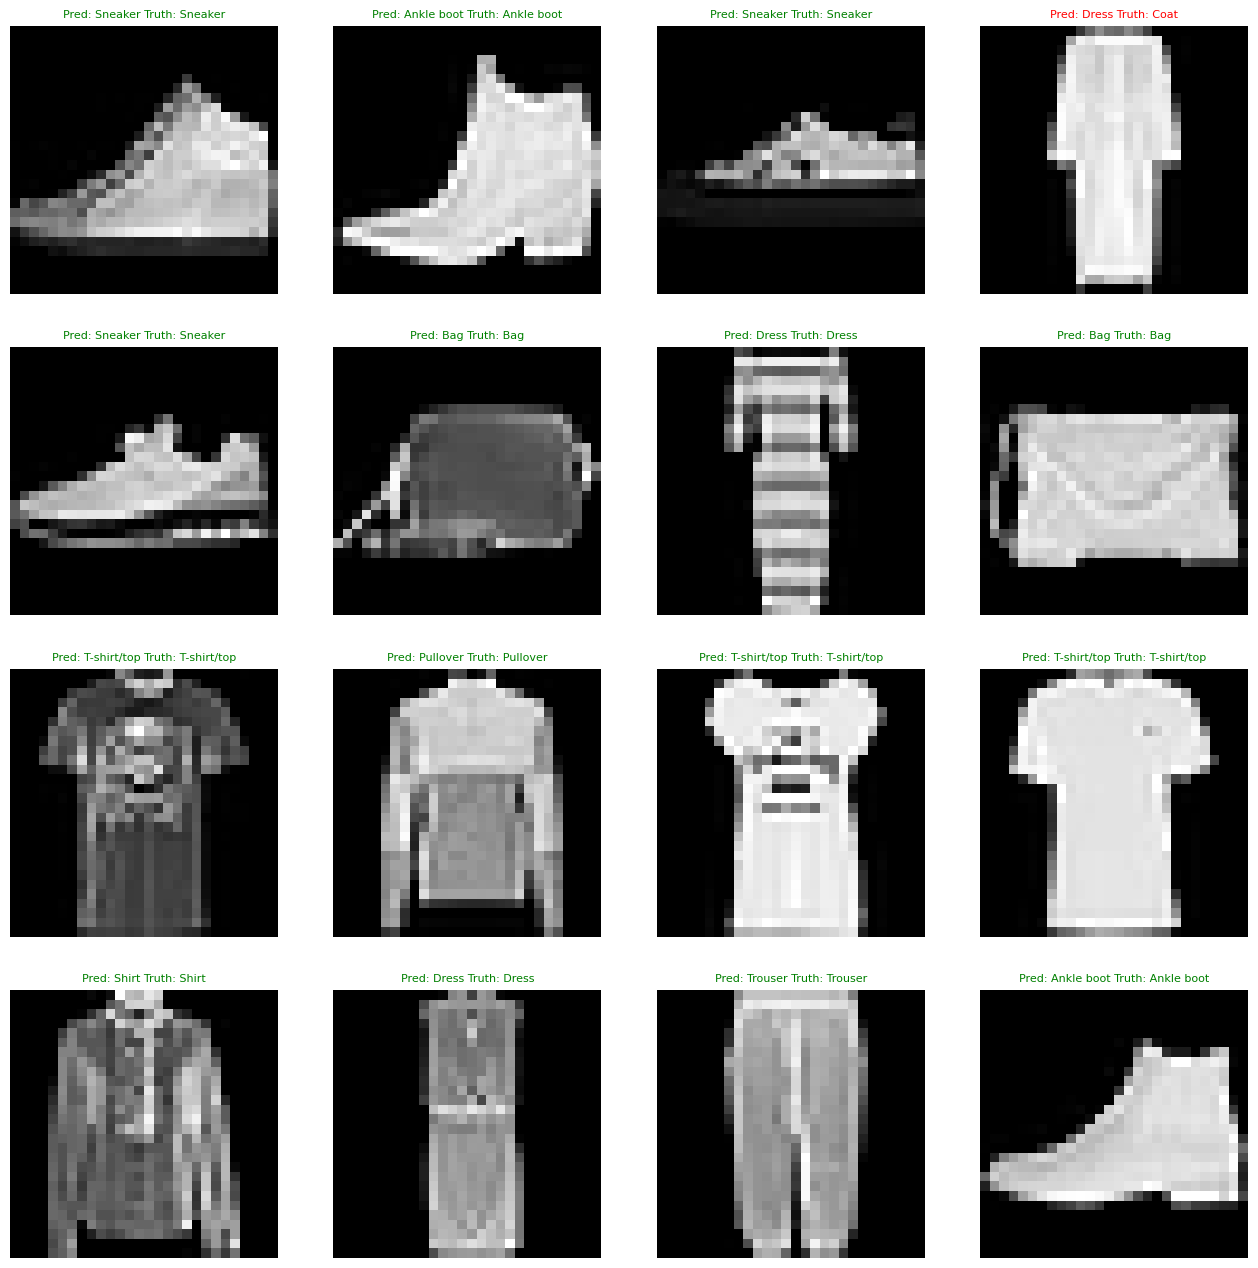

In [17]:
eval_model(model=tiny, data=test_data)

In [18]:
#See if required packages are installed and if not, install them:
import subprocess
import sys

try:
    import torchmetrics, mlxtend
    print(f"torchmetrics version: {torchmetrics.__version__}\nmlxtend version: {mlxtend.__version__}")
    #assert condition, error_message (optional)
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
    subprocess.check_call([sys.executable, "-m", "pip", "install", torchmetrics])
    subprocess.check_call([sys.executable, "-m", "pip", "install", mlxtend])

    #^idk if that would work, found the commands on StackOverflow but I already had both installed via command line using pip so idk

torchmetrics version: 0.11.4
mlxtend version: 0.22.0


In [24]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install mlxtend --upgrade --no-deps #for upgrading in googlecolab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
#Eval model

pred_list = []

tiny.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = torch.softmax(tiny(X), dim=1).argmax(dim=1)
    pred_list.append(pred.cpu())

model_preds_tensor = torch.cat(pred_list)



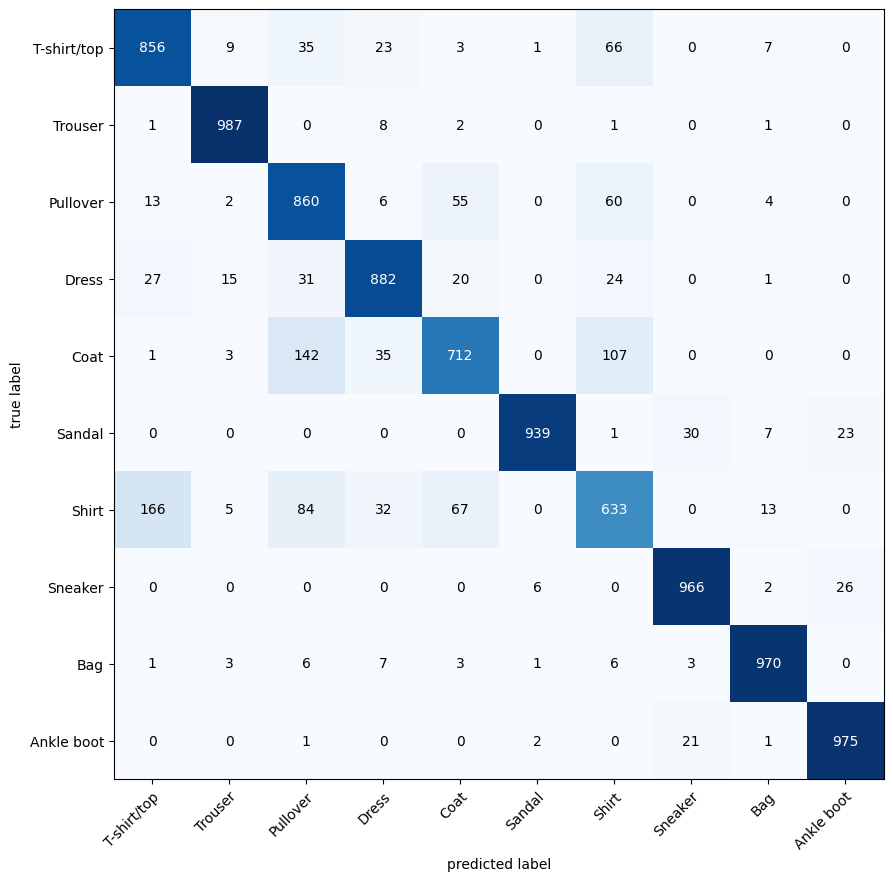

In [30]:
#Confusion matrix
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

cmatrix = ConfusionMatrix(task="multiclass", num_classes = 10, num_labels = 10)
cmatrix_tensor = cmatrix(preds=model_preds_tensor, target=test_data.targets)

fig, x = plot_confusion_matrix(conf_mat=cmatrix_tensor.numpy(), class_names=test_data.classes, figsize=(10, 10))